## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [9]:
treatment = df[df.group == 'treatment']
err1 = treatment[treatment.landing_page != 'new_page']
control = df[df.group == 'control']
err2 = control[control.landing_page != 'old_page']
err1.shape[0]+err2.shape[0]

3893

f. Do any of the rows have missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
df2 = df.drop(df.query('group == "control" and landing_page == "new_page"').index, inplace=False)
df2 = df2.drop(df2.query('group == "treatment" and landing_page == "old_page"').index, inplace=False)
df2.shape

(290585, 5)

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [13]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

c. What is the row information for the repeat **user_id**? 

In [14]:
users = df2['user_id']
df2[users.isin(users[users.duplicated()])]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop([1899])

In [16]:
print(df2.user_id.nunique(), df2.shape[0])

290584 290584


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
df2[df2.group=='control'].converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
df2[df2.group=='treatment'].converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [20]:
len(df2[df2.landing_page=='new_page'])/len(df2)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Since there's a near even distribution of users who got the new landing page and those who got the old landing page, the conversion rate of the 2 pages can be compared. There seems to be a slight edge for the control group with an extra 0.12% conversion rate. However, we haven't taken into consideration the duration of the test and so there could be biased due to change aversion.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0 : p_{old} >= p_{new}$$
$$H_1 : p_{old} < p_{new}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
df2.converted.mean()

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
df2.converted.mean()

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
len(df2[df2.group=='treatment'])

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
len(df2[df2.group=='control'])

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([1,0], p=[df2.converted.mean(), 1-df2.converted.mean()], size=145310)
pnew = new_page_converted.mean()

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([1,0], p=[df2.converted.mean(), 1-df2.converted.mean()], size=145274)
pold = old_page_converted.mean()

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
pnew - pold


0.0006241540840198484

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []
for _ in range(10000):
    pold = np.random.choice([1,0], p=[df2.converted.mean(), 1-df2.converted.mean()], size=145274).mean()
    pnew = np.random.choice([1,0], p=[df2.converted.mean(), 1-df2.converted.mean()], size=145310).mean()
    p_diffs.append(pnew-pold)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   31.,   133.,   621.,  1718.,  2840.,  2618.,  1489.,   446.,
           93.,    11.]),
 array([-0.00437281, -0.00347461, -0.00257641, -0.00167822, -0.00078002,
         0.00011818,  0.00101637,  0.00191457,  0.00281277,  0.00371096,
         0.00460916]),
 <a list of 10 Patch objects>)

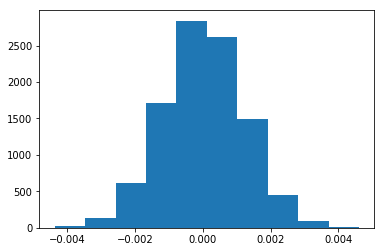

In [29]:
plt.hist(p_diffs)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

**Yes, it's normally distributed which is consistent with the central limit theorem: with a big enough sample size, a sampling distribution will be normally distributed.**

In [30]:
p_diffs = np.array(p_diffs)
act_diff = df2[df2.group=='treatment'].converted.mean() - df2[df2.group=='control'].converted.mean()
(p_diffs>act_diff).mean()

0.90949999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**This is the p-value which is the probability of obtaining the observed statistic or a "more extreme" value if the null hypothesis is true. A p-value is used to make a decision. If the p-value is less than the $\alpha$ value then we usually reject the null hypothesis and are in favor of the alternate hypothesis. In this case, the $\alpha$ value is 0.05 and our p-value is 0.91 and so we fail to reject the null hypothesis since $0.91 > 0.05$**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

convert_old = len(df2.query("group == 'control' and converted == '1'"))
convert_new = len(df2.query("group == 'treatment' and converted == '1'"))
n_old = len(df2[df2.group=='control'])
n_new = len(df2[df2.group=='treatment'])
print(convert_old, convert_new, n_old, n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
from statsmodels.stats.proportion import proportions_ztest
zstat, p_value = proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(zstat, p_value)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Given that the default "value" value in proportions_ztest means that the z-test is run on a null hypothesis of $p_{new} - p_{old} = 0$, the given zstat should represent $p_{new}-p_{old}$ and the p-value can be interpreted similarly to the previous calculations. Since $0.91 > 0.05$ therefore, we fail to reject the null hypothesis once again.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression since we are trying to predict a categorical response variable**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
model = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
res = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-17 13:14 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [37]:
1/np.exp(-0.0150)

1.0151130646157189

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.1899. It differs from the value in Part 2 because this p-value represents how statistically significant this value is in predicting conversion rate while the p-value in Part 2 represented something else as previously mentioned.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Test Duration (which we can deduce through timestamps) is important in order to minimize the interference of things like change aversion and the novelty effect in existing users. Other factors we can consider might include if users end up converting on different products or items and taking into considerations the differences between said items if there exists. Also maybe looking at what pages users start their navigation from because that might make a substantial difference.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
countries = pd.read_csv('countries.csv')
df2 = df2.merge(countries, on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,US


In [39]:
df2[df2.user_id == 928468]

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,country
155203,928468,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,US


In [40]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2.country)

In [41]:
model2 = sm.Logit(df2['converted'], df2[['CA', 'UK', 'intercept']])
res = model2.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-17 13:14 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
==================================================================

"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
model3 = sm.Logit(df2['converted'], df2[['CA', 'UK', 'intercept', 'ab_page']])
res = model3.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-17 13:15 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

In [116]:
1/np.exp(-0.0149), 1/np.exp(0.0099), 1/np.exp(-0.0408)

(1.0150115583846535, 0.99014884368295708, 1.0416437559600236)

In [44]:
df2['CA_new'] = df2['CA'] * df2['ab_page']
df2['UK_new'] = df2['UK'] * df2['ab_page']
model4 = sm.Logit(df2['converted'], df2[['CA', 'UK', 'intercept', 'ab_page','CA_new', 'UK_new']])
res = model4.fit()
res.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-09-17 13:15 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA_new       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_new        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

**It can be interpreted from the above results that the old page is 1.015 times more likely to have users convert than the new page. Also, it seems out of the 3 countries in this test, the UK seems to have the highest conversion rate. Although, for both of these observations, the difference is very small, the p-values show that the difference in page conversion rates is statistically significant. The same can't be clearly said about the countries**

**Based on all the previous results, through multiple approaches, it's very clear that the new page will not provide better performance and results than the old page. Through all methodologies, we have failed to reject the null hypothesis. 
I would suggest that the company stick to the old page.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0